In [1]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
!pip install transformers
nltk.download('punkt')
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from nltk.tokenize import word_tokenize


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
df=pd.read_csv("/content/drive/MyDrive/Youtube Project/IPL2018 - Commentary Data (2).csv")
df.dropna()
# df = df.head(20)
# df.head()

,over,short_text,long_text
0,18.3,"Brathwaite to Rayudu, FOUR runs",And Chennai Super Kings' highest run-scorer hi...
1,18.2,"Brathwaite to Rayudu, no run","full just outside off, and Rayudu suffles acro..."
2,18.1,"Brathwaite to Rayudu, no run","yorker on off, and dug away to the square-leg ..."
3,17.6,"Kaul to Watson, no run","full just outside off, and defended towards co..."
4,17.5,"Kaul to Watson, FOUR runs","full just outside off, and this time it's been..."
...,...,...,...
14084,0.5,"Chahar to Rohit Sharma, 1 run","full and veering into the pads, Rohit tucks it..."
14085,0.4,"Chahar to Rohit Sharma, FOUR runs","slightly overpitched and outside off, Rohit do..."
14086,0.3,"Chahar to Rohit Sharma, no run",beaten three times in a row! Good length and b...
14087,0.2,"Chahar to Rohit Sharma, no run","on a length and outside off, Chahar finds outs..."


In [17]:
df['over'][0]

18.3

In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm

In [13]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [14]:
def scores_roberta(example):
  encoded_text=tokenizer(example,return_tensors='pt')
  output=model(**encoded_text)
  scores=output[0][0].detach().numpy()
  scores=softmax(scores)
  scores_dict={'roberta_neg': scores[0],
             'roberta_neu': scores[1],
             'roberta_pos': scores[2]}
  return scores_dict


In [18]:
res=[]
for i,row in tqdm(df.iterrows(),total=len(df)):
  try:
    text=row['long_text']
    roberta_result=scores_roberta(text)
    res.append(roberta_result)
    i=i+1
  except ValueError:
    res.append(0)
    print("broke")

print(res)


  0%|          | 0/14089 [00:00<?, ?it/s]

broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
broke
[{'roberta_neg': 0.0027345957, 'roberta_neu': 0.19020557, 'roberta_pos': 0.8070598}, {'roberta_neg': 0.04367534, 'roberta_neu': 0.90021145, 'roberta_pos': 0.056113232}, {'roberta_neg': 0.095122166, 'roberta_neu': 0.8515253, 'roberta_pos': 0.053352583}, {'roberta_neg': 0.051341362, 'roberta_neu': 0.8830362, 'roberta_pos': 0.065622464}, {'roberta_neg': 0.06485016, 'roberta_neu': 0.78293675, 'roberta_pos': 0.15221317}, {'roberta_neg': 0.033353623, 'roberta_neu': 0.7384263, 'roberta_pos': 0.22822008}, {'roberta_neg': 0.062322333, 'roberta_neu': 0.89488375, 'roberta_pos': 0.04279397}, {'roberta_neg': 0.09393551, 'roberta_neu': 0.8673, 'roberta_pos': 0.03876455}, {'roberta_neg': 0.013782386, 'roberta_neu': 0.789439, 'roberta_pos': 0.19677866}, {'roberta_neg': 0.4435736, 'roberta_

In [19]:
len(res)

14089

In [20]:
res=np.array(res)
df['roberta_results']=res

In [21]:
df['roberta_results'][5]


{'roberta_neg': 0.033353623,
 'roberta_neu': 0.7384263,
 'roberta_pos': 0.22822008}

In [22]:
df = df.drop(df[df['roberta_results'] == 0].index)

In [23]:
def get_max_sentiment(row):
    max_value = max(row['roberta_results'].values())
    if row['roberta_results']['roberta_pos'] == max_value:
        return 'positive'
    elif row['roberta_results']['roberta_neg'] == max_value:
        return 'negative'
    else:
        return 'neutral'

# Iterate through all rows and create 'max' column
df['Max_Attribute'] = df.apply(get_max_sentiment, axis=1)



In [24]:
df['Max_Attribute']

0        positive
1         neutral
2         neutral
3         neutral
4         neutral
           ...   
14084     neutral
14085    negative
14086    positive
14087     neutral
14088    positive
Name: Max_Attribute, Length: 14053, dtype: object

In [25]:
res_li=list(df['Max_Attribute'])

In [26]:
df['Max_Attribute'].head()

0    positive
1     neutral
2     neutral
3     neutral
4     neutral
Name: Max_Attribute, dtype: object

In [27]:
res_pos=res_li.count('positive')
res_neu=res_li.count('neutral')
res_neg=res_li.count('negative')

In [28]:
res_pos

1585

In [61]:
res_neg

765

In [62]:
res_neu

11703

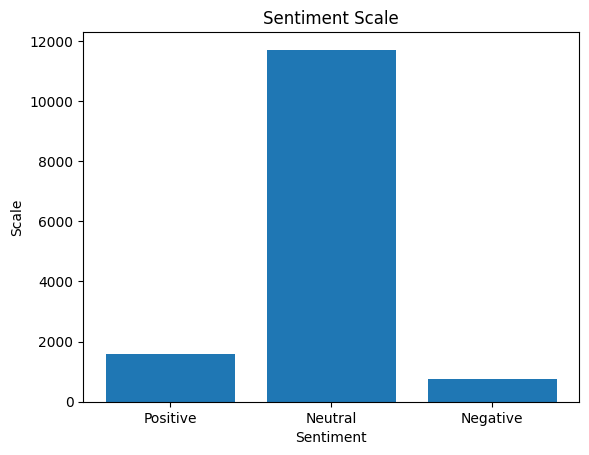

In [29]:
import matplotlib.pyplot as plt
# Categories
categories = ['Positive', 'Neutral', 'Negative']
values = [res_pos, res_neu, res_neg]
# Create the bar graph
plt.bar(categories, values)

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Scale')
plt.title('Sentiment Scale')

# Display the graph
plt.show()


In [30]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns

In [31]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [32]:
def get_roberta_sentiment(example):
    roberta_result = scores_roberta(example)
    max_sentiment = max(roberta_result, key=roberta_result.get)
    return max_sentiment

In [33]:
get_roberta_sentiment(df['long_text'][0])

'roberta_pos'

In [34]:
test_df['predicted_sentiment'] = test_df['long_text'].apply(get_roberta_sentiment)


In [35]:
test_df['predicted_sentiment'].head()

3470     roberta_neu
14041    roberta_neu
3890     roberta_neu
286      roberta_neu
9361     roberta_neu
Name: predicted_sentiment, dtype: object

In [36]:
test_df['predicted_sentiment_short'] = test_df['short_text'].apply(get_roberta_sentiment)


In [37]:
accuracy = accuracy_score(test_df['predicted_sentiment_short'], test_df['predicted_sentiment'])
accuracy

0.8281750266808965

In [38]:
precision = precision_score(test_df['predicted_sentiment_short'], test_df['predicted_sentiment'], average='weighted')
precision

1.0

In [39]:
print(test_df['predicted_sentiment_short'].unique())

['roberta_neu']


In [40]:
print(test_df['predicted_sentiment'].unique())

['roberta_neu' 'roberta_pos' 'roberta_neg']


In [41]:
conf_matrix = confusion_matrix(test_df['predicted_sentiment_short'], test_df['predicted_sentiment'], labels=['roberta_pos', 'roberta_neu', 'roberta_neg'])


In [42]:
f1 = f1_score(test_df['predicted_sentiment_short'], test_df['predicted_sentiment'], average='weighted')
f1

0.9060128429655574

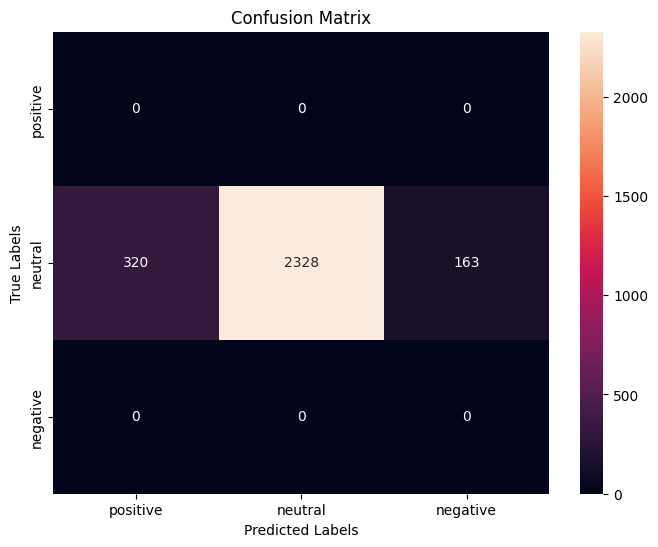

In [43]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [53]:
pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.1 MB/s eta 0:00:00


In [54]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import openai

In [55]:
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

In [56]:
# Set pad token ID to EOS token ID for open-end generation
model.config.pad_token_id = tokenizer.eos_token_id

In [57]:
# Define a function to generate commentary using GPT-3.5
def generate_commentary(sentiment, prompt):
    input_text = f"{sentiment.capitalize()} sentiment: {prompt}"
    input_ids = gpt2_tokenizer.encode(input_text, return_tensors="pt")
    with torch.no_grad():
        output = gpt2_model.generate(input_ids, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2)
    generated_commentary = gpt2_tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_commentary

In [ ]:
# # Iterate through rows and generate commentary
# generated_comments = []
# for i, row in test_df.iterrows():
#     sentiment = row['predicted_sentiment']
#     prompt = row['long_text']

#     # Generate commentary based on sentiment and prompt
#     generated_comment = generate_commentary(sentiment, prompt)  # Replace with your generation function
#     generated_comments.append(generated_comment)

# test_df['generated_comment'] = generated_comments


In [58]:
generated_comments = []
for i, row in test_df.iterrows():
    sentiment = row['predicted_sentiment']
    prompt = row['long_text']

    input_ids = tokenizer.encode(prompt, return_tensors='pt', max_length=1024, truncation=True)

    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)
    attention_mask[input_ids == tokenizer.pad_token_id] = 0

    generated_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=100)
    generated_comment = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    generated_comments.append(generated_comment)

test_df['generated_comment'] = generated_comments


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 125, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 106, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py

In [59]:
len(test_df['generated_comment'])

2811

In [66]:
test_df['generated_comment']

3470     clobbered deep over deep midwicket! Stands his...
14041    round-arm dart from Jadeja, Kishan exploits th...
3890     punches this length delivery to long on for a ...
286      punched down to long on as he jogs the single-...
9361     diving catch from Kishan! Angling away from Kl...
                               ...                        
9909     tries to make room, but Woakes doesn't allow s...
5359     gorgeous on-drive as he fronts a 149 kph deliv...
1118     a review this time. Ngidi must have charming e...
9327     139 kph, a low full toss on leg, worked down t...
11217    length on leg stump, looks to flick but it pin...
Name: generated_comment, Length: 2811, dtype: object